to create the complete_patientstayid_list.csv, which contains any patients with CAM-ICUs, ICDSCs or delirium diagnoses that had ICU stays of at least 12 hours. This represents all the patients we might ever use, for prediction or clustering.

In [ ]:
# importing packages and path
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt


#### change the path into where all the data files from eICU has been saved
eicu_path = "/Users/jaewon/Desktop/eicu/"

In [ ]:
pat = pd.read_csv(eicu_path+"patient.csv")
pat.columns

Index(['patientunitstayid', 'patienthealthsystemstayid', 'gender', 'age',
       'ethnicity', 'hospitalid', 'wardid', 'apacheadmissiondx',
       'admissionheight', 'hospitaladmittime24', 'hospitaladmitoffset',
       'hospitaladmitsource', 'hospitaldischargeyear',
       'hospitaldischargetime24', 'hospitaldischargeoffset',
       'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype',
       'unitadmittime24', 'unitadmitsource', 'unitvisitnumber', 'unitstaytype',
       'admissionweight', 'dischargeweight', 'unitdischargetime24',
       'unitdischargeoffset', 'unitdischargelocation', 'unitdischargestatus',
       'uniquepid'],
      dtype='object')

count    200859.000000
mean       3858.131913
std        6236.445188
min       -7687.000000
25%        1179.000000
50%        2266.000000
75%        4279.000000
max      729176.000000
Name: unitdischargeoffset, dtype: float64


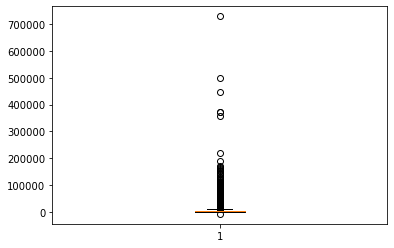

In [ ]:
# exploring discharge offset distribution
pat = pd.read_csv(eicu_path+"patient.csv", usecols=['patientunitstayid', 'unitdischargeoffset'])
print(pat.unitdischargeoffset.describe())
plt.boxplot(pat['unitdischargeoffset'])
plt.show()

In [ ]:
## Find all CAM-ICUs and delirium diagnoses.
# Exploring the nurse charting data

nurse_data = pd.read_csv(eicu_path+"nurseCharting.csv", usecols=['nursingchartid'])
print("# total charting :",nurse_data.shape)

# total charting : (151604232, 1)


In [ ]:
nurse_data = pd.read_csv(r"/Users/jaewon/Desktop/eicu/nurseCharting.csv", nrows=5)
nurse_data.head()

# nursingchartoffset : chart time
# nursinghcartentryoffset : validation time

,nursingchartid,patientunitstayid,nursingchartoffset,nursingchartentryoffset,nursingchartcelltypecat,nursingchartcelltypevallabel,nursingchartcelltypevalname,nursingchartvalue
0,221469923,141924,5714,5714,Vital Signs,Temperature,Temperature (C),36.6
1,277425167,141924,12964,12964,Other Vital Signs and Infusions,Genitourinary Assessment,Value,X
2,236464484,141924,3844,3844,Vital Signs,Heart Rate,Heart Rate,97
3,253552049,141924,124,124,Vital Signs,Non-Invasive BP,Non-Invasive BP Systolic,106
4,147240923,141924,1489,1489,Other Vital Signs and Infusions,MAP (mmHg),Value,71


In [ ]:
# nursingchartcelltypevalname - type of diagnoses
diagnosis_data_unq = pd.read_csv(r"/Users/jaewon/Desktop/eicu/nurseCharting.csv",
                                 usecols=['nursingchartcelltypevalname'], nrows=5000000)
diag_unq = diagnosis_data_unq['nursingchartcelltypevalname'].sort_values().unique()
print(diag_unq)

['Bedside Glucose' 'CI' 'End Tidal CO2' 'Eyes' 'GCS Total' 'Heart Rate'
 'Invasive BP Diastolic' 'Invasive BP Mean' 'Invasive BP Systolic' 'Motor'
 'Non-Invasive BP Diastolic' 'Non-Invasive BP Mean'
 'Non-Invasive BP Systolic' 'O2 Admin Device' 'O2 L/%' 'O2 Saturation'
 'PVR' 'Pain Score' 'Respiratory Rate' 'Temperature (C)' 'Temperature (F)'
 'Temperature Location' 'Value' 'Verbal']


In [ ]:
# importing the charting dataset only with the relevant columns that includes delirium information

cols = ['nursingchartid','patientunitstayid','nursingchartoffset','nursingchartentryoffset','nursingchartcelltypevalname','nursingchartvalue']
nurse_data = pd.read_csv(eicu_path+"nurseCharting.csv", usecols = cols, nrows=0)
for chunk in pd.read_csv(eicu_path+"nurseCharting.csv",
                         usecols = cols, chunksize=200000000):
    temp_rows = chunk[chunk['nursingchartcelltypevalname']=='Delirium Score']
    nurse_data = pd.concat([nurse_data,temp_rows])

In [ ]:
nurse_data

,nursingchartid,patientunitstayid,nursingchartoffset,nursingchartentryoffset,nursingchartcelltypevalname,nursingchartvalue
18070629,314693418,242154,10084,10084,Delirium Score,No
18070780,314369911,242154,7815,7815,Delirium Score,NaN
18070964,309192775,242154,2078,2078,Delirium Score,NaN
18071050,306615554,242154,4250,4250,Delirium Score,NaN
18071139,310354618,242154,9277,9277,Delirium Score,No
...,...,...,...,...,...,...
151432889,2296037975,3353077,1250,1250,Delirium Score,No
151432937,2306759707,3353077,4730,4730,Delirium Score,No
151433016,2312346753,3353077,4610,4610,Delirium Score,No
151433018,2312620385,3353077,1490,1490,Delirium Score,No


In [ ]:
# unique patient ids
print("# rows in the nursingchart :", nurse_data.nursingchartid.unique().shape[0])
print("# unique patients ids that have delirium info :", nurse_data.patientunitstayid.unique().shape[0])

# rows in the nursingchart : 287899
# unique patients ids that have delirium info : 28108


In [ ]:
# chart value distribution
nurse_data.groupby('nursingchartcelltypevalname')['nursingchartvalue'].apply(lambda x: x.str.lower() if x.dtype == 'object' else x).value_counts()

no     205723
yes     34119
0        9630
1        2097
2        2013
3        1417
4        1016
5         575
6         317
7         137
8          49
Name: nursingchartvalue, dtype: int64

In [ ]:
nurse_data.dropna(subset=['nursingchartvalue'], inplace=True)
nurse_data.shape

(257093, 6)

In [ ]:
# function to convert the values to 1s or 0s (1 for positive for delirium, 0 for negative).
def get_delirium_testing(value):
    # Check if value is a string
    if isinstance(value, str) and value.lower() == 'yes':
        return 1
    elif isinstance(value, str) and value.lower() == 'no':
        return 0
    # Check if value is a number
    elif isinstance(value, (int, float)) and value >= 4:
        return 1
    else:
        return 0

# applying the function
nurse_data['del_positive'] = nurse_data.apply(
    lambda row: get_delirium_testing(row['nursingchartvalue']),axis=1)
nurse_data

,nursingchartid,patientunitstayid,nursingchartoffset,nursingchartentryoffset,nursingchartcelltypevalname,nursingchartvalue,del_positive
18070629,314693418,242154,10084,10084,Delirium Score,No,0
18071139,310354618,242154,9277,9277,Delirium Score,No,0
18072052,305300824,242154,8620,8620,Delirium Score,No,0
18072230,313397085,242154,6372,6372,Delirium Score,Yes,1
18073427,307650993,242154,10720,10720,Delirium Score,No,0
...,...,...,...,...,...,...,...
151432889,2296037975,3353077,1250,1250,Delirium Score,No,0
151432937,2306759707,3353077,4730,4730,Delirium Score,No,0
151433016,2312346753,3353077,4610,4610,Delirium Score,No,0
151433018,2312620385,3353077,1490,1490,Delirium Score,No,0


In [ ]:
nurse_data_copy = nurse_data.copy()

In [ ]:
# Find the earliest value of 'del_positive' being 1 for each patient unit stay ID
# Find the latest value of 'del_positive' being 0 for each patient unit stay ID

del_offset_pos = nurse_data[nurse_data['del_positive'] == 1].groupby('patientunitstayid')['nursingchartoffset'].min().reset_index()
del_offset_neg = nurse_data[nurse_data['del_positive'] == 0].groupby('patientunitstayid')['nursingchartoffset'].max().reset_index()

print(del_offset_pos.shape) # positive cases
print(del_offset_neg.shape) # negative cases -> this includes the patient ids that has positive case

print("# patients that has >0 charting value :", nurse_data.patientunitstayid.unique().shape[0])
print("# patients that has never been diagnosed as positive :", nurse_data.patientunitstayid.unique().shape[0]-del_offset_neg.shape[0])
print("# patients that has been diagnosed >0 times as positive :", del_offset_pos.shape[0])

(5508, 2)
(26108, 2)
# patients that has >0 charting value : 27250
# patients that has never been diagnosed as positive : 1142
# patients that has been diagnosed >0 times as positive : 5508


In [ ]:
# Merge 'del_offset_neg' with 'del_offset_pos' on 'patientunitstayid'
final_offset = pd.merge(del_offset_neg, del_offset_pos, on='patientunitstayid', suffixes=('_neg', '_pos'), how='outer')

# if the patient has not diagnosed as positive at all -> del_positive 0
final_offset['del_positive'] = final_offset['nursingchartoffset_pos'].notna().astype(int).fillna(0)

# final offset: the earliest positive diagnosis offset, otherwise the latest negative diagnosis offset
final_offset['final_offset'] = final_offset['nursingchartoffset_pos'].fillna(final_offset['nursingchartoffset_neg'])
final_offset

,patientunitstayid,nursingchartoffset_neg,nursingchartoffset_pos,del_positive,final_offset
0,242154,10720.0,5640.0,1,5640.0
1,242290,1362.0,NaN,0,1362.0
2,242474,807.0,NaN,0,807.0
3,242505,5180.0,5900.0,1,5900.0
4,242714,2712.0,NaN,0,2712.0
...,...,...,...,...,...
27245,3347353,NaN,4.0,1,4.0
27246,3347960,NaN,651.0,1,651.0
27247,3349086,NaN,574.0,1,574.0
27248,3349342,NaN,10390.0,1,10390.0


In [ ]:
# Leave the final offset only
final_offset.drop(['nursingchartoffset_neg', 'nursingchartoffset_pos'], axis=1, inplace=True)
final_offset

,patientunitstayid,del_positive,final_offset
0,242154,1,5640.0
1,242290,0,1362.0
2,242474,0,807.0
3,242505,1,5900.0
4,242714,0,2712.0
...,...,...,...
27245,3347353,1,4.0
27246,3347960,1,651.0
27247,3349086,1,574.0
27248,3349342,1,10390.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb661152790>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb66115cbd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb6f1b87590>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb66115ce50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb66115cd10>],
 'means': []}

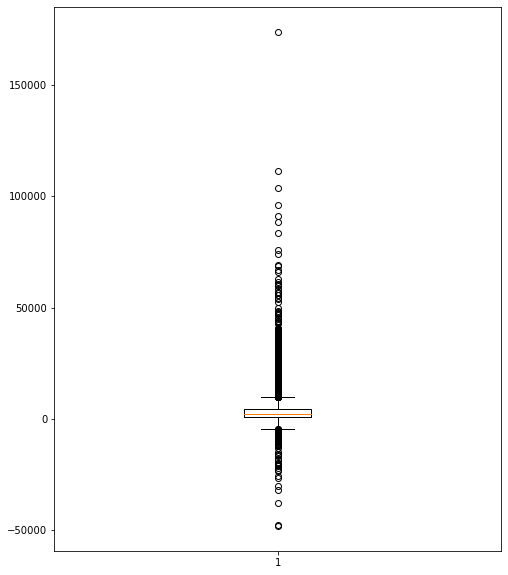

In [ ]:
# exploration of the final offset distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 10))
plt.boxplot(final_offset['final_offset'])

In [ ]:
# remove the cases that has delirium diagnosis which contradicts the delirium test result
# Remove cases that had delirium diagnoses but no positive CAM-ICU/ICDSC.

#Get delirium diagnosis data.
diagnosis_data = pd.read_csv(r"/Users/jaewon/Desktop/eicu/diagnosis.csv")
diagnosis_data = diagnosis_data[diagnosis_data["diagnosisstring"]=='neurologic|altered mental status / pain|delirium']
print(diagnosis_data.shape)
print(diagnosis_data.patientunitstayid.unique().shape) # unique patientunitstayid
diagnosis_data

(7710, 7)
(1586,)


,diagnosisid,patientunitstayid,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
5153,3471586,149134,True,204,neurologic|altered mental status / pain|delirium,"293.0, F05",Other
5349,4220242,149321,True,2216,neurologic|altered mental status / pain|delirium,"293.0, F05",Other
5351,3755740,149321,False,15,neurologic|altered mental status / pain|delirium,"293.0, F05",Other
6241,4136107,150934,False,826,neurologic|altered mental status / pain|delirium,"293.0, F05",Major
6413,4185377,151213,True,1108,neurologic|altered mental status / pain|delirium,"293.0, F05",Other
...,...,...,...,...,...,...,...
2710426,46221708,3353197,False,15951,neurologic|altered mental status / pain|delirium,"293.0, F05",Major
2710431,46221289,3353197,False,9763,neurologic|altered mental status / pain|delirium,"293.0, F05",Major
2710437,46221498,3353197,False,4566,neurologic|altered mental status / pain|delirium,"293.0, F05",Other
2710442,46221093,3353197,False,2460,neurologic|altered mental status / pain|delirium,"293.0, F05",Other


In [ ]:
diag = diagnosis_data[['patientunitstayid']].drop_duplicates()
no_pos_test = final_offset[final_offset['del_positive']==0]
diag_but_no_pos= diag.merge(no_pos_test,how='inner',on='patientunitstayid')
print("# contradicting case :", diag_but_no_pos.patientunitstayid.unique().shape)
diag_but_no_pos
# resulting in 187 rows

# contradicting case : (187,)


,patientunitstayid,del_positive,final_offset
0,264458,0,10756.0
1,264459,0,23314.0
2,285325,0,3389.0
3,425564,0,1679.0
4,464000,0,485.0
...,...,...,...
182,3159582,0,3537.0
183,3184376,0,2272.0
184,3327039,0,2471.0
185,3331500,0,7933.0


In [ ]:
# remove from the previous label/id/offest df
final_offset = final_offset[~final_offset.patientunitstayid.isin(diag_but_no_pos.patientunitstayid)]
print(final_offset.del_positive.value_counts())
print("final # patients for static model :", final_offset.shape[0])
final_offset

0    21555
1     5508
Name: del_positive, dtype: int64
final # patients for static model : 27063


,patientunitstayid,del_positive,final_offset
0,242154,1,5640.0
1,242290,0,1362.0
2,242474,0,807.0
3,242505,1,5900.0
4,242714,0,2712.0
...,...,...,...
27245,3347353,1,4.0
27246,3347960,1,651.0
27247,3349086,1,574.0
27248,3349342,1,10390.0


In [ ]:
# ratio of contradicting cases
n_delscore_pos = nurse_data[nurse_data['del_positive']==0].shape[0]
n_delscore_neg = nurse_data[nurse_data['del_positive']==1].shape[0]
n_delscore_neg_diag_yes = diag_but_no_pos.shape[0]

print("among "+str(n_delscore_pos)+" positive case and "+str(n_delscore_neg)+" negative case, "+str(n_delscore_neg_diag_yes)+" cases are negative on score but diagnosed positive")
print("Charting YES / whole =", round(n_delscore_pos/nurse_data.shape[0],4))
print("Charting NO / whole =", round(n_delscore_neg/nurse_data.shape[0],4))
print("Charting No and diagnosed YES / whole =", round(n_delscore_neg_diag_yes/nurse_data.shape[0],4))
print("Charting No and diagnosed YES / whole =", round(n_delscore_neg_diag_yes/n_delscore_neg,4))

among 222974 positive case and 34119 negative case, 187 cases are negative on score but diagnosed positive
Charting YES / whole = 0.8673
Charting NO / whole = 0.1327
Charting No and diagnosed YES / whole = 0.0007
Charting No and diagnosed YES / whole = 0.0055


In [ ]:
final_offset.rename(columns={"del_positive": "Class"}, inplace=True)
final_offset

,patientunitstayid,Class,final_offset
0,242154,1,5640.0
1,242290,0,1362.0
2,242474,0,807.0
3,242505,1,5900.0
4,242714,0,2712.0
...,...,...,...
27245,3347353,1,4.0
27246,3347960,1,651.0
27247,3349086,1,574.0
27248,3349342,1,10390.0


In [ ]:
final_offset_rev.to_csv('complete_patientstayid_label_list.csv',index=False)

### For Dynamic Model

In [ ]:
# negative cases with the offset value >0 and <0
temp = final_offset[final_offset['Class']==0]

print(temp[temp['final_offset']>0].shape) # rows of interest
print(temp[temp['final_offset']<0].shape)

(21025, 3)
(515, 3)


In [ ]:
# positive cases with the offset value >0 and <0
temp = final_offset[final_offset['Class']==1]

print(temp[temp['final_offset']>0].shape) # rows of interest
print(temp[temp['final_offset']<0].shape)

(4899, 3)
(577, 3)


In [ ]:
# patient ids with the diagnosis offset value >1440 and <1440
print("# diagnoses after 24hr:", final_offset[final_offset['final_offset']>1440].shape[0]) # rows of interest
print("# diagnoses before 24hr:",final_offset[final_offset['final_offset']<1440].shape[0])

# diagnosis after 24hr: 16434
# diagnosis before 24hr: 10624


In [ ]:
# patient ids with positive diagnosis offset value >1440 and <1440
temp = final_offset[final_offset['Class']==1]

print("# positive diagnoses after 24hr:", temp[temp['final_offset']>1440].shape[0]) # rows of interest
print("# positive diagnoses before 24hr:", temp[temp['final_offset']<1440].shape[0])

# positive diagnoses after 24hr: 2363
# positive diagnoses before 24hr: 3144


In [ ]:
# patient ids with negative diagnosis offset value >1440 and <1440
temp = final_offset[final_offset['Class']==0]

print("# negative diagnoses after 24hr:", temp[temp['final_offset']>1440].shape[0]) # rows of interest
print("# negative diagnoses before 24hr:", temp[(temp['final_offset']>0)&(temp['final_offset']<1440)].shape[0])

# negative diagnoses after 24hr: 14071
# negative diagnoses before 24hr: 6950
